The gihub repo is at: https://github.com/KayvanJ/final_project_602


The website is found at: https://web-production-f732.up.railway.app/

In [3]:
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

This portion of the code we used to clone the TMDB Database, it is commented out to keep it from running accidentally, as it takes days to complete execution.

In [6]:
# def get_movie(id: int):
#     response = requests.get(
#         f"https://api.themoviedb.org/3/movie/{id}?api_key=c3f3f6d8b79b1295b90154fa221469ef&append_to_response=credits")

#     code = response.status_code
#     if code == 404:
#         return

#     if code != 200:
#         print(code)

#     return response.json()

# def write_json(new_data, filename='movie_db.json'):
#     with open(filename,'r+') as file:
#         file_data = json.load(file)
#         # Join new_data with file_data inside emp_details
#         file_data["movies"].append(new_data)
#         # Sets file's current position at offset.
#         file.seek(0)
#         # convert back to json.
#         json.dump(file_data, file)

# def in_db(path: str, id: int):
#     f = open(path)
#     db = json.load(f)
#     for mov in db["movies"]:
#         if mov:
#             if mov.get("id") == id:
#                 f.close()
#                 return True
#     f.close()
#     return False
    
# start = 0
# end = 800000
# current_db = 0

# for id in range(start, end+1):
#     path = f"movie_db{current_db}.json"
#     try: 
#         if not in_db(path=path, id=id):
#             with open(path,'r+') as file:
#                 file_data = json.load(file)
#                 movie = get_movie(id=id)
#                 if movie:
#                     print(f"writing {id} in db {current_db} | currently # {len(file_data['movies'])}")
#                     file_data["movies"].append(movie)
#                     file.seek(0)
#                     json.dump(file_data, file)
                
#                 if len(file_data["movies"]) > 500:
#                     current_db += 1

#                 file.close()
            
#     except:
#         print("new file", path)
#         file = open(path, 'w')
#         file.write('{"movies": []}')
#         file.close()

After getting all the data cloned, we load it

In [4]:
f = open(f'final_db.json')
db = json.load(f)
f.close()

print(f"movies available = {len(db)}")

movies available = 11666


We clean the data

In [6]:
def convert(x):
    try:
        return datetime.strptime(x, '%Y-%m-%d')
    except:
        return np.nan

df = pd.DataFrame.from_dict(db)

df['release_date'] = df['release_date'].apply(lambda x: convert(x))
df['count_g'] = df['genres'].apply(lambda x: len(x))
df['cast%M'] = df['credits'].apply(lambda x: sum(i['gender'] == 2 for i in x['cast'])/len(x['cast']) if len(x['cast']) != 0 else np.nan)
df['crew%M'] = df['credits'].apply(lambda x: sum(i['gender'] == 2 for i in x['crew'])/len(x['crew']) if len(x['crew']) != 0 else np.nan)
df['#cast'] = df['credits'].apply(lambda x: len(x['cast']))
df['#crew'] = df['credits'].apply(lambda x: len(x['crew']))
df['days_out'] = df['release_date'].apply(lambda x: (datetime.now() - x).days)
df['total_popularity'] = df['credits'].apply(lambda x: sum(i['popularity'] for i in x['cast'][:10]))

for i, row in df.iterrows():
    temp_year = row['release_date'].year
    temp_budget = row['budget']
    temp_revenue = row['revenue']
    df.loc[i,'revenue/day'] = temp_revenue/row['days_out']

df['anomaly'] = df['revenue'].apply(lambda x: 1 if x > (72287747*2) else 0)

df['genre1'] = df['genres'].apply(lambda x: x[0]['name'] if x else "None")
df['genre1id'] = df['genres'].apply(lambda x: x[0]['id'] if x else 0)

df = df[df["revenue"] != 0]
df = df[df["status"] == "Released"]

avg_budget = df['budget'].mean()
std_budget = df['budget'].std()
avg_revenue = df['revenue'].mean()
std_revenue = df['revenue'].std()

df['centered_budget'] = df['budget'].apply(lambda x: (x-avg_budget)/std_budget)
df['centered_revenue'] = df['revenue'].apply(lambda x: (x-avg_revenue)/std_revenue)
df.dropna(subset=['revenue/day'], inplace=True)
df.head()
len(df)

11666

In [7]:
df.describe()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,count_g,cast%M,crew%M,#cast,#crew,days_out,revenue/day,anomaly,genre1id,centered_budget,centered_revenue,total_popularity
count,1.166600e+04,11666.000000,11666.000000,1.166600e+04,11666.000000,11666.000000,11666.000000,11666.000000,11579.000000,11592.000000,11666.000000,11666.000000,11666.000000,1.166600e+04,11666.000000,11666.000000,1.166600e+04,1.166600e+04,11666.000000
mean,1.661105e+07,95207.129265,13.626733,5.030433e+07,104.984913,6.154484,1109.986113,2.384365,0.519639,0.486347,28.333362,43.205812,8442.571918,1.317734e+04,0.092234,891.553746,9.745143e-18,1.522679e-17,90.289716
std,3.324698e+07,117619.304294,17.583463,1.346463e+08,27.715336,1.336698,2527.866925,1.083267,0.189893,0.228549,22.391437,62.618744,6362.239798,8.930775e+04,0.289368,2862.483704,1.000000e+00,1.000000e+00,67.012933
min,0.000000e+00,5.000000,0.600000,-1.200000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,152.000000,-3.429551e-03,0.000000,0.000000,-4.996258e-01,-3.736037e-01,0.000000
25%,0.000000e+00,11622.500000,4.028250,8.051130e+05,92.000000,5.698000,32.000000,2.000000,0.400000,0.333333,14.000000,11.000000,4002.500000,9.624068e+01,0.000000,18.000000,-4.996258e-01,-3.676241e-01,34.309750
50%,2.705449e+06,37946.500000,9.374000,6.813793e+06,102.000000,6.301000,200.500000,2.000000,0.530201,0.468147,22.000000,21.000000,6383.000000,9.459851e+02,0.000000,28.000000,-4.182515e-01,-3.229985e-01,77.136500
75%,1.800000e+07,146151.500000,16.705000,3.654643e+07,116.000000,6.936000,936.000000,3.000000,0.652174,0.636364,36.750000,48.000000,10924.750000,5.436852e+03,0.000000,35.000000,4.177681e-02,-1.021781e-01,133.879000
max,5.000000e+08,406997.000000,492.049000,2.920357e+09,960.000000,10.000000,32666.000000,8.000000,1.000000,1.000000,348.000000,978.000000,39831.000000,7.303724e+06,1.000000,10770.000000,1.453934e+01,2.131550e+01,419.662000


We plot the variables to examine visually

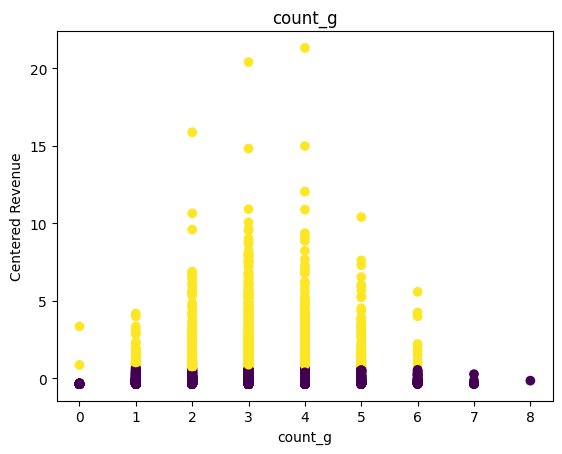

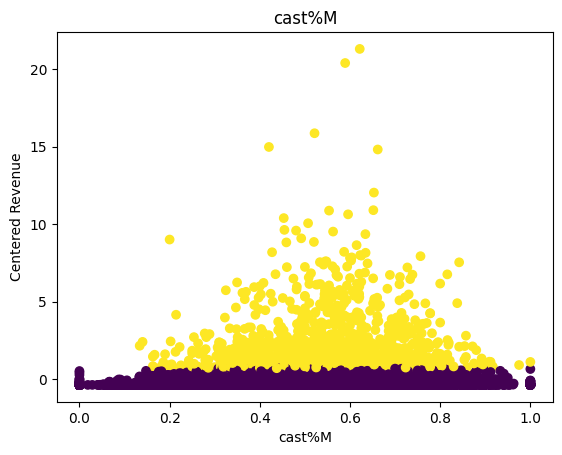

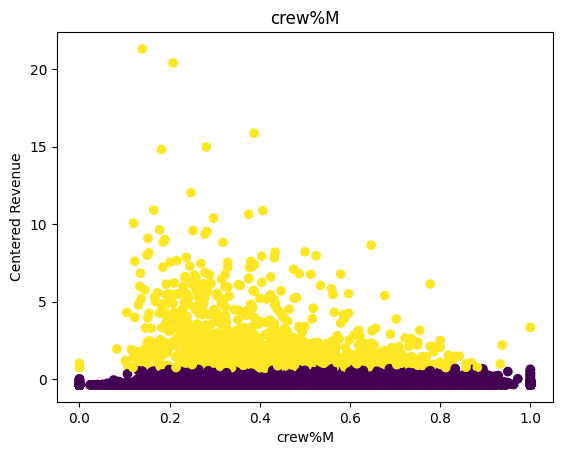

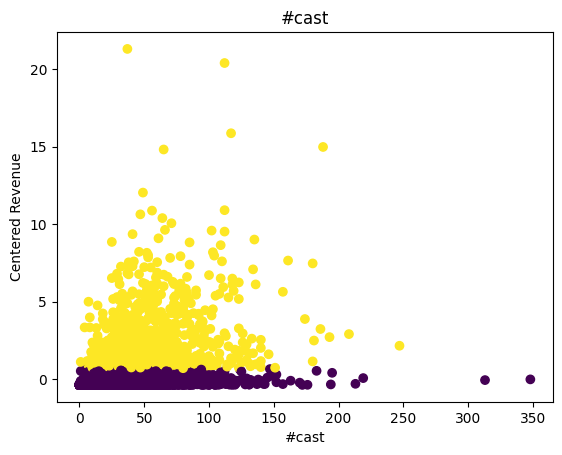

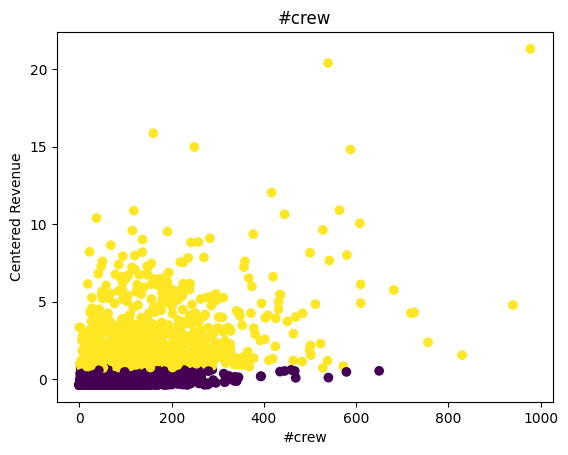

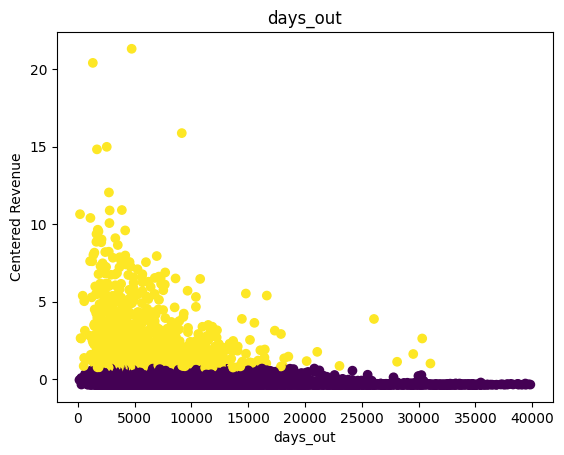

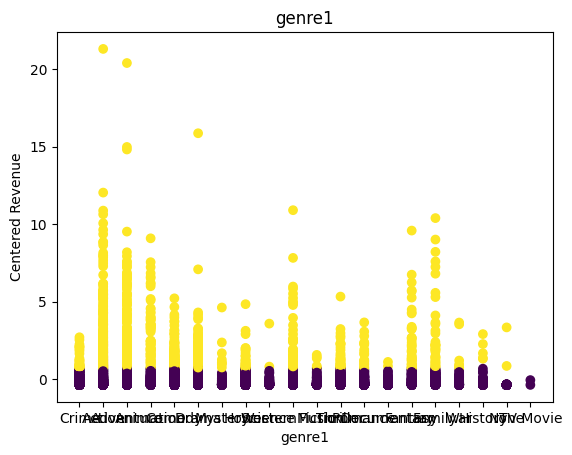

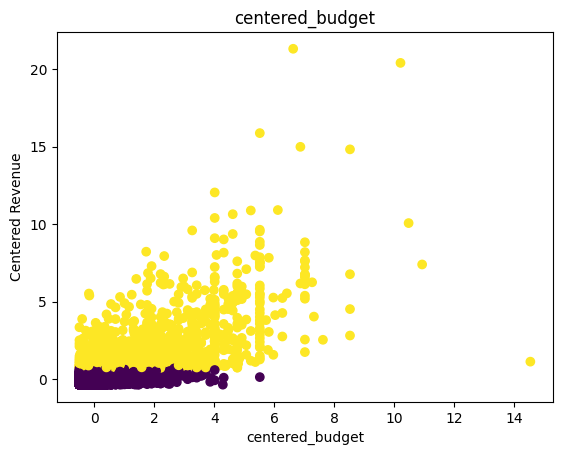

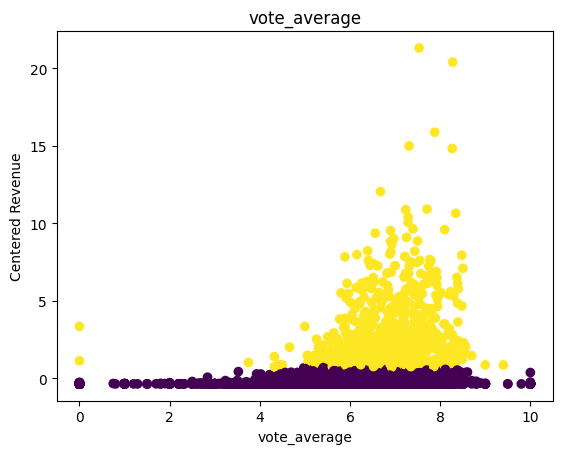

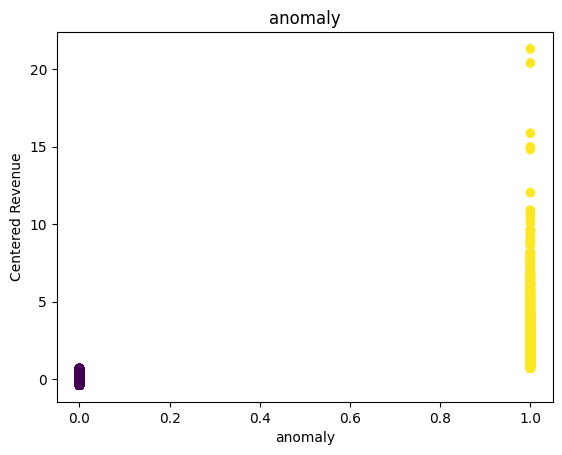

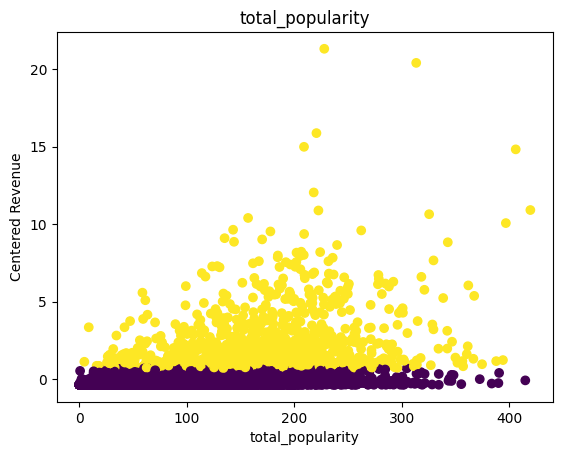

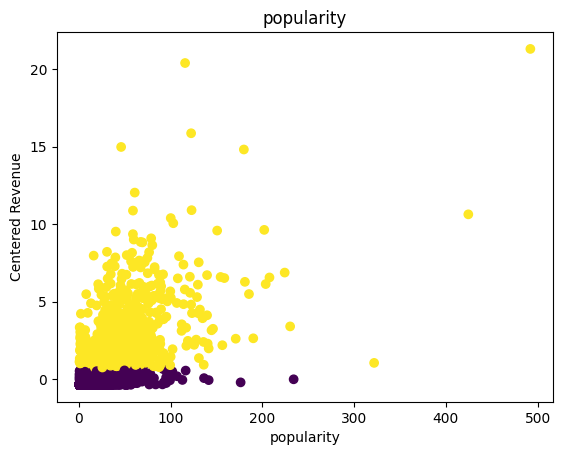

In [8]:
for chart in ['count_g', 'cast%M', 'crew%M', "#cast", "#crew", 'days_out', 'genre1', 'centered_budget', 'vote_average', 'anomaly', 'total_popularity', 'popularity']:
    plt.scatter(df[chart], df['centered_revenue'], c=df['anomaly'])
    plt.title(chart)
    plt.xlabel(chart)
    plt.ylabel("Centered Revenue")
    plt.show()

We run models on the entire set without PCA

In [9]:
X = np.array([df['centered_budget'], df['vote_count'], df['popularity'], df['anomaly']]).T
y = np.array(df['centered_revenue']).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state= 101)

models = {
    "GradBoost" : GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=1, random_state=0,loss='squared_error'),
    "MLP" : MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1),
    "LR" : LinearRegression(),
    "SVM" : SVR(),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(name)
    print(model.score(X_test, y_test))
    print("MSE:", mean_squared_error(y_true=y_test,y_pred=y_pred))
    # print(model.feature_importances_)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradBoost
0.7899449143931556
MSE: 0.17446276098342325


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

MLP
0.7190009758004868
MSE: 0.23338575904442393
LR
0.7664044033958614
MSE: 0.19401450157415318
SVM
0.5985854533412875
MSE: 0.3333977366302158


Then with PCA

In [10]:
scalar = StandardScaler()
scalar.fit(X)
scaled_data = scalar.transform(X)
  
pca = PCA(n_components = 2)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
y = np.array(df['centered_revenue']).reshape(-1, 1)

PCA_train, PCA_test, y_train, y_test = train_test_split(x_pca, y, test_size = 0.25, random_state= 101)

models = {
    "GradBoost" : GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=1, random_state=0,loss='squared_error'),
    "LR" : LinearRegression(),
    "SVM" : SVR(),
    "MLP" : MLPRegressor(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1),
}

for name, model in models.items():
    model.fit(PCA_train, y_train)
    y_pred = model.predict(PCA_test)
    print(name)
    print(model.score(PCA_test, y_test))
    print("MSE:", mean_squared_error(y_true=y_test,y_pred=y_pred))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradBoost
0.8101165340211058
MSE: 0.15770907733119108
LR
0.7611358008753122
MSE: 0.19839037726220782


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVM
0.7664312924112378
MSE: 0.19399216870918518


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLP
0.8174247458060986
MSE: 0.15163918951020386


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Then we separate the data into anomaly or not, and rerun all the previous models.

In [11]:
data1 = df[df['anomaly'] == 0]
data2 = df[df['anomaly'] == 1]
for i, data in enumerate([data1, data2]):
    if i == 0:
        print("\n\n Non anomaly ###################")
    else:
        print("\n\n Anomaly ###################")

    X = np.array([df['centered_budget'], df['days_out'], df['#cast'], df['#crew'], df['vote_average'], df['vote_count'], df['popularity'], df['total_popularity'], df['anomaly']]).T
    y = np.array(df['centered_revenue']).reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state= 101)

    models = {
        "GradBoost" : GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=1, random_state=0,loss='squared_error'),
        "MLP" : MLPRegressor(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1),
        "LR" : LinearRegression(),
        "SVM" : SVR(),
    }

    print("\nNO PCA")
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print(name)
        print(model.score(X_test, y_test))
        print("MSE:", mean_squared_error(y_true=y_test,y_pred=y_pred)/100000)


    print("\n\nPCA")
    scalar = StandardScaler()
    scalar.fit(X)
    scaled_data = scalar.transform(X)
    
    pca = PCA(n_components = 6)
    pca.fit(scaled_data)
    x_pca = pca.transform(scaled_data)

    PCA_train, PCA_test, y_train, y_test = train_test_split(x_pca, y, test_size = 0.25, random_state= 101)

    models = {
        "GradBoost" : GradientBoostingRegressor(n_estimators=1000, learning_rate=0.1, max_depth=1, random_state=0,loss='squared_error'),
        "MLP" : MLPRegressor(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15,), random_state=1),
        "LR" : LinearRegression(),
        "SVM" : SVR(),
    }

    for name, model in models.items():
        model.fit(PCA_train, y_train)
        y_pred = model.predict(PCA_test)
        print(name)
        print(model.score(PCA_test, y_test))
        print("MSE:", mean_squared_error(y_true=y_test,y_pred=y_pred)/100000)
    
    print("#############################")



 Non anomaly ###################

NO PCA


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradBoost
0.7907608679796754
MSE: 1.7378506486800993e-06


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

MLP
-16.25368236447032
MSE: 0.0001433016988729555
LR
0.7725686024240221
MSE: 1.8889478177019129e-06
SVM
0.6221457097957546
MSE: 3.138295963081235e-06


PCA


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradBoost
0.7945195446217213
MSE: 1.7066326896994461e-06


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

MLP
0.8322617839608356
MSE: 1.3931618083934174e-06
LR
0.7568178834863233
MSE: 2.019766545818216e-06
SVM
0.7554758621706851
MSE: 2.0309128003041964e-06
#############################


 Anomaly ###################

NO PCA


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradBoost
0.7907608679796754
MSE: 1.7378506486800993e-06


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

MLP
-16.25368236447032
MSE: 0.0001433016988729555
LR
0.7725686024240221
MSE: 1.8889478177019129e-06
SVM
0.6221457097957546
MSE: 3.138295963081235e-06


PCA


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/ensemble/_gb.py:570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradBoost
0.7945195446217213
MSE: 1.7066326896994461e-06


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1607: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to

MLP
0.8324113824036236
MSE: 1.3919193077754392e-06
LR
0.7568178834863231
MSE: 2.0197665458182175e-06
SVM
0.7554758621721622
MSE: 2.0309128002919284e-06
#############################
